In [1]:
from csv import DictReader

with open('Product_Predictions.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

print(len(rows))

271


In [2]:
import math

def rank_cn(cn: float) -> float:

    if cn < 30:
        return 0.0
    if cn < 40:
        return 0.5
    if cn < 60:
        return 1.0
    return 0.5

def rank_ysi(ysi: float) -> float:

    if ysi < 150:
        return 1.0
    if ysi < 250:
        return 0.5
    return 0.0

def rank_lhv(lhv: float) -> float:

    if lhv < 10:
        return 0.0
    if lhv < 20:
        return 0.25
    if lhv < 30:
        return 0.5
    return 1.0

def rank_kv(kv: float) -> float:

    if kv < 1.9:
        return 0.0
    if kv < 6.0:
        return 1.0
    return 0.0

def rank_cp(cp: float) -> float:

    if cp < 0:
        return 1.0
    if cp < 10:
        return 0.5
    return 0.0

def rank_fp(fp: float) -> float:

    if fp < 50:
        return 0
    if fp < 75:
        return 0.5
    if fp < 125:
        return 1.0
    if fp < 150:
        return 0.5
    return 0.0

def rank(row: dict) -> float:

    rank = 0.0
    rank += rank_cn(float(row['Pred. CN'])) * 2
    rank += rank_ysi(float(row['Pred. YSI'])) * 1
    rank += rank_lhv(float(row['Pred. LHV'])) * 2
    rank += rank_kv(float(row['Pred. KV'])) * 1
    rank += rank_cp(float(row['Pred. CP'])) * 1
    rank += rank_fp(float(row['Pred. FP'])) * 1
    return rank

def normalize_ranks(ranks: list) -> list:

    minval = min(ranks)
    maxval = max(ranks)
    return [(r - minval) / (maxval - minval) for r in ranks]

# ranks = normalize_ranks([rank(r) for r in rows])
ranks = [rank(r) for r in rows]

print(min(ranks), max(ranks))

2.0 6.5


In [3]:
from string import ascii_uppercase

col_ids = {}
for idx, letter in enumerate(ascii_uppercase[1:-2]):  # letters B through X
    col_ids[letter] = idx

print(len(col_ids))

23


In [4]:
import numpy as np
import re

rank_matrix = np.zeros((len(col_ids), len(col_ids)))
rank_matrix += np.mean(ranks)
for idx, row in enumerate(rows):
    found = False
    for id in list(col_ids.keys()):
        if id in row['LOCATION']:
            found = True
            col_id = col_ids[id]
            break
    if not found:
        continue
    row_re = re.search(r'\d\d', row['LOCATION'])
    if row_re is None:
        row_re = re.search(r'\d', row['LOCATION'])
    row_id = int(row_re.group()) - 2
    rank_matrix[row_id][col_id] = ranks[idx]

for i in range(len(col_ids)):
    for j in range(len(col_ids)):
        rank_matrix[j][i] = rank_matrix[i][j]

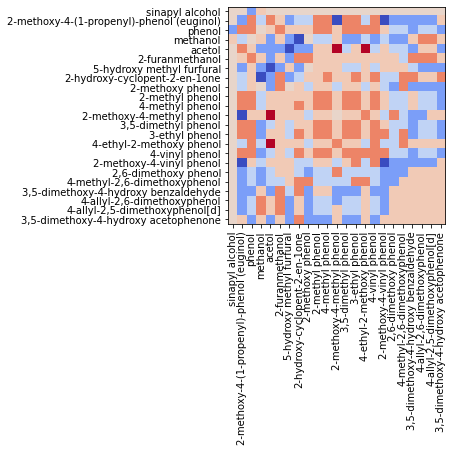

In [5]:
from matplotlib import pyplot as plt

rank_matrix = np.concatenate((
    rank_matrix[19:21],
    rank_matrix[:19],
    rank_matrix[21:]
))
for i in range(len(rank_matrix)):
    rank_matrix[i] = np.concatenate((
        rank_matrix[i][19:21],
        rank_matrix[i][:19],
        rank_matrix[i][21:]
    ))

labels = [
    'sinapyl alcohol',
    '2-methoxy-4-(1-propenyl)-phenol (euginol)',
    'phenol',
    'methanol',
    'acetol',
    '2-furanmethanol',
    '5-hydroxy methyl furfural',
    '2-hydroxy-cyclopent-2-en-1one',
    '2-methoxy phenol',
    '2-methyl phenol',
    '4-methyl phenol',
    '2-methoxy-4-methyl phenol',
    '3,5-dimethyl phenol',
    '3-ethyl phenol',
    '4-ethyl-2-methoxy phenol',
    '4-vinyl phenol',
    '2-methoxy-4-vinyl phenol',
    '2,6-dimethoxy phenol',
    '4-methyl-2,6-dimethoxyphenol',
    '3,5-dimethoxy-4-hydroxy benzaldehyde',
    '4-allyl-2,6-dimethoxyphenol',
    '4-allyl-2,5-dimethoxyphenol[d]',
    '3,5-dimethoxy-4-hydroxy acetophenone'
]

plt.imshow(rank_matrix, cmap='coolwarm', interpolation='nearest')
plt.xticks([i for i in range(len(col_ids))], labels, rotation=90)
plt.yticks([i for i in range(len(col_ids))], labels)
plt.show()